In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
print(f'Number of users: {len(df.userId.unique())}')
print(f'Number of movies: {len(df.movieId.unique())}')

Number of users: 610
Number of movies: 9724


In [4]:
class MovieRecommenderDataset(Dataset):
    def __init__(self, users, movies, ratings):
        super().__init__()
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        users = self.users[idx]
        movies = self.movies[idx]
        ratings = self.ratings[idx]
        return (torch.tensor(users, dtype=torch.long), 
               torch.tensor(movies, dtype=torch.long),
               torch.tensor(ratings, dtype=torch.long))

In [5]:
class RecSysMatFacModel(nn.Module):
    def __init__(self, n_users, n_movies, n_embeddings = 48, dropout_rate=0.5):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, n_embeddings)
        self.movie_embed = nn.Embedding(n_movies, n_embeddings)
        #self.out = nn.Linear(n_embeddings * 2, 1)
        self.inner = nn.Linear(n_embeddings * 2, 8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(8, 1)
        
    def forward(self, users, movies):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        x = torch.cat([user_embeds, movie_embeds], dim=1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        return x

In [6]:
user_label = preprocessing.LabelEncoder()
movie_label = preprocessing.LabelEncoder()

df['user_id'] = user_label.fit_transform(df['userId'])
df['movie_id'] = movie_label.fit_transform(df['movieId'])

training_data = df[['user_id','movie_id','rating']]
df_train, df_test = train_test_split(training_data, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
train_dataset = MovieRecommenderDataset(
    users = df_train['user_id'], 
    movies = df_train['movie_id'],  
    ratings = df_train['rating']
)

test_dataset = MovieRecommenderDataset(
    users = df_test['user_id'], 
    movies = df_test['movie_id'],  
    ratings = df_test['rating']
)

In [8]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
model = RecSysMatFacModel(
    n_users=len(user_label.classes_),
    n_movies=len(movie_label.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [11]:
EPOCHS = 15
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    for users, movies, ratings in train_loader:
        optimizer.zero_grad()
        y_pred = model(users.to(device), movies.to(device))
        y = ratings.unsqueeze(dim=1).to(device, dtype=torch.float32)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    epoch_test_loss = 0
    model.eval()
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            y_pred = model(users.to(device), movies.to(device))
            y = ratings.unsqueeze(dim=1).to(device, dtype=torch.float32)
            loss = criterion(y_pred, y) 
            epoch_test_loss += loss.item()

    test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch {epoch} train loss: {train_loss:.3f} test loss: {test_loss:3f}')



Epoch 0 train loss: 3.785 test loss: 1.194282
Epoch 1 train loss: 1.479 test loss: 1.020563
Epoch 2 train loss: 1.046 test loss: 0.934013
Epoch 3 train loss: 0.940 test loss: 0.888995
Epoch 4 train loss: 0.899 test loss: 0.866646
Epoch 5 train loss: 0.871 test loss: 0.855766
Epoch 6 train loss: 0.856 test loss: 0.847094
Epoch 7 train loss: 0.846 test loss: 0.835352
Epoch 8 train loss: 0.835 test loss: 0.841196
Epoch 9 train loss: 0.830 test loss: 0.842392
Epoch 10 train loss: 0.824 test loss: 0.838288
Epoch 11 train loss: 0.814 test loss: 0.832821
Epoch 12 train loss: 0.812 test loss: 0.834944
Epoch 13 train loss: 0.807 test loss: 0.834028
Epoch 14 train loss: 0.805 test loss: 0.837053


* Epoch 0 train loss: 2.170 test loss: 1.094722
* Epoch 1 train loss: 0.994 test loss: 0.991268
* Epoch 2 train loss: 0.913 test loss: 0.944877
* Epoch 3 train loss: 0.852 test loss: 0.916100
* Epoch 4 train loss: 0.805 test loss: 0.895416
* Epoch 5 train loss: 0.770 test loss: 0.888239
* Epoch 6 train loss: 0.744 test loss: 0.884470
* Epoch 7 train loss: 0.722 test loss: 0.883764
* Epoch 8 train loss: 0.704 test loss: 0.883689
* Epoch 9 train loss: 0.689 test loss: 0.880740
* Epoch 10 train loss: 0.674 test loss: 0.886643
* Epoch 11 train loss: 0.661 test loss: 0.888921
* Epoch 12 train loss: 0.649 test loss: 0.897028
* Epoch 13 train loss: 0.637 test loss: 0.901812
* Epoch 14 train loss: 0.628 test loss: 0.908723
* Epoch 15 train loss: 0.618 test loss: 0.912671
* Epoch 16 train loss: 0.610 test loss: 0.917678
* Epoch 17 train loss: 0.601 test loss: 0.922549
* Epoch 18 train loss: 0.593 test loss: 0.929092
* Epoch 19 train loss: 0.585 test loss: 0.936124

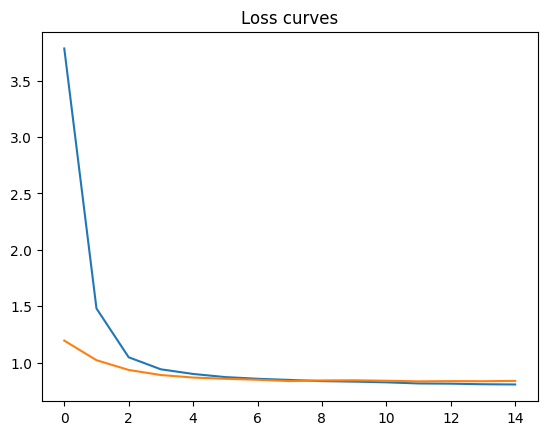

In [12]:
sns.lineplot(x=range(EPOCHS), y=train_losses)
sns.lineplot(x=range(EPOCHS), y=test_losses)
plt.title('Loss curves')
plt.show()

In [13]:
df_val = df_test.sample(10, random_state=1)
df_val

,user_id,movie_id,rating
168,287,888,3.0
2385,598,4355,2.5
11751,561,510,5.0
15683,602,834,3.0
6349,598,3104,2.5
19132,413,353,2.0
6366,287,763,1.0
5322,56,1008,3.0
18212,595,5722,2.0
387,136,4670,3.0


In [14]:
model = model.to('cpu')

model.eval()
with torch.inference_mode():
    for _, row in df_val.iterrows():
        user_id = torch.tensor(row.user_id, dtype=torch.long).unsqueeze(0)
        movie_id = torch.tensor(row.movie_id, dtype=torch.long).unsqueeze(0)
        y_pred = model(user_id, movie_id)
        y = row.rating
        uid = user_id.item()
        mid = movie_id.item()
        y = int(y)
        y_pred = y_pred[0].item()
        print(f'User {uid}, movie {mid}, rating {y}, predicted {y_pred:.2f}')


User 287, movie 888, rating 3, predicted 3.33
User 598, movie 4355, rating 2, predicted 2.88
User 561, movie 510, rating 5, predicted 4.17
User 602, movie 834, rating 3, predicted 4.13
User 598, movie 3104, rating 2, predicted 3.18
User 413, movie 353, rating 2, predicted 2.87
User 287, movie 763, rating 1, predicted 2.47
User 56, movie 1008, rating 3, predicted 2.80
User 595, movie 5722, rating 2, predicted 2.90
User 136, movie 4670, rating 3, predicted 3.14


* User 287, movie 888, rating 3, predicted 3.47
* User 598, movie 4355, rating 2, predicted 2.61
* User 561, movie 510, rating 5, predicted 4.23
* User 602, movie 834, rating 3, predicted 4.00
* User 598, movie 3104, rating 2, predicted 3.02
* User 413, movie 353, rating 2, predicted 3.24
* User 287, movie 763, rating 1, predicted 2.04
* User 56, movie 1008, rating 3, predicted 3.03
* User 595, movie 5722, rating 2, predicted 2.63
* User 136, movie 4670, rating 3, predicted 3.09

In [15]:
user_movie_test = defaultdict(list)

model.eval()
with torch.inference_mode():
    for _, row in df_test.iterrows():
        user_id = torch.tensor(row.user_id, dtype=torch.long).unsqueeze(0)
        movie_id = torch.tensor(row.movie_id, dtype=torch.long).unsqueeze(0)
        y_pred = model(user_id, movie_id)[0].item()
        y = row.rating
        uid = user_id.item()
        mid = movie_id.item()
        user_movie_test[uid].append((y_pred, y))


In [16]:
precisions = {}
recalls = {}

k = 10
treshold = 3.5

In [17]:
for user_id, user_ratings in user_movie_test.items():
    user_ratings.sort(key= lambda x: x[0], reverse=True)

    # The relevant items are the ones that got an actual (true) rating of 4 or higher.    
    # We don't want to recommend things that people don't like
    number_relevant = sum((true_rating >= treshold) for (_, true_rating) in user_ratings)

    # Number of recommended items that are predicted to the relevant and in the top k
    num_pred_rel_k = sum((rating_pred >= treshold) for (rating_pred, _) in user_ratings[:k])

    # number of top ten (relevant) items where ground truth and prediction see the result north or 3.5    
    num_rel_and_re = sum((rating_pred > 3.5) and (true_rating > 3.5) for (rating_pred, true_rating) in user_ratings[:k])

    #print(f'User: {user_id}')
    #print(f'number_relevant: {number_relevant} | num_pred_rel_k: {num_pred_rel_k} | num_rel_and_re: {num_rel_and_re}')

    precisions[user_id] = num_rel_and_re / num_pred_rel_k if num_pred_rel_k != 0 else 0
    recalls[user_id] = num_rel_and_re / number_relevant if number_relevant != 0 else 0

In [18]:
precisions_mean = sum(precisions.values()) / len(precisions)
print(f'Precision@k: {precisions_mean}')

recalls_mean = sum(recalls.values()) / len(recalls)
print(f'Recall@k: {recalls_mean}')

Precision@k: 0.6397913571558898
Recall@k: 0.43251288388915793


* Precision@k: 0.6507017749628594
* Recall@k: 0.44402831647470553